# Control Tektronix AWG7122B

In [3]:
# -*- coding: utf-8 -*-
#!/usr/bin/env python
# coding:utf-8

__author__ = "Thomas Ferreira de Lima"
__copyright__ = "Copyright 2020, Lightwave Lab, Princeton University"
__credits__ = ""
__license__ = ""
__version__ = "0.0.1"
__maintainer__ = ""
__email__ = "tlima@princeton.edu"
__status__ = "developping"

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import numpy as np
import time

In [21]:
isHot = True
isGathering = isHot
isSaving = isGathering and True

In [12]:
import sys
import lightlab.util.io as io
project_path = str(io.projectDir)
# if project_path not in sys.path:
#     sys.path.append(project_path)

## AWG parameters

In [ ]:
bitrate = 10e6  # this is the base frequency
samp_rate_MHz = 4000
cutoff = 15e6

f_start = bitrate
f_end = bitrate * 10

# I only have a window of 100us. I'd like to sweep from 10MHz to 100MHz, so df_dt = 90MHz / 100us = 9e11
df_dt = 9e11


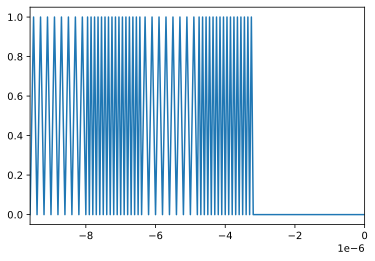

In [16]:
from waves import triangle_wave
pilot_period = 96/bitrate
t_pilot = np.arange(-pilot_period, 0, 1e-6/samp_rate_MHz)
pilot_wav1 = triangle_wave(t_pilot, 2/bitrate, -pilot_period, t_end=-5*pilot_period/6)
pilot_wav1 += triangle_wave(t_pilot, 1/bitrate, -5*pilot_period/6, t_end=-2*pilot_period/3)
pilot_wav1 += triangle_wave(t_pilot, 2/bitrate, -2*pilot_period/3, t_end=-pilot_period/2)
pilot_wav1 += triangle_wave(t_pilot, 1/bitrate, -pilot_period/2, t_end=-pilot_period/3)
pilot_wav1.simplePlot()

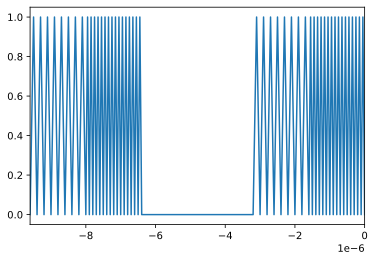

In [15]:
from waves import triangle_wave
pilot_period = 96/bitrate
t_pilot = np.arange(-pilot_period, 0, 1e-6/samp_rate_MHz)
pilot_wav2 = triangle_wave(t_pilot, 2/bitrate, -pilot_period, t_end=-5*pilot_period/6)
pilot_wav2 += triangle_wave(t_pilot, 1/bitrate, -5*pilot_period/6, t_end=-2*pilot_period/3)
pilot_wav2 += triangle_wave(t_pilot, 2/bitrate, -pilot_period/3, t_end=-pilot_period/6)
pilot_wav2 += triangle_wave(t_pilot, 1/bitrate, -pilot_period/6, t_end=0)
pilot_wav2.simplePlot()

## Define other waveforms here, if necessary

Then, add them to the pilot waves

In [18]:
awg_input1 = pilot_wav1
awg_input2 = pilot_wav2

In [19]:
dac_input1 = 2 * awg_input1 ** 0.5 - 1
dac_input2 = 2 * awg_input2 ** 0.5 - 1

### Connect to instrument

In [23]:
from lightlab.equipment.lab_instruments.AWG_7122b import AWG_7122

if isHot:
    awg = AWG_7122('GPIB2::4::INSTR')
    assert awg.print_idn() == "TEKTRONIX,AWG7122B,B010110,SCPI:99.0 FW:3.3.182.755\n", awg.print_idn()
else:
    awg = MockInstrument()

### Upload waveforms

In [24]:
awg.upload_waveform("PILOT_SINEWAV_CH1", dac_input1.ordi)
awg.upload_waveform("PILOT_SINEWAV_CH2", dac_input2.ordi)

### Set waveforms to respective channels

In [25]:
awg.set_waveform("PILOT_SINEWAV_CH1", 1)
awg.set_waveform("PILOT_SINEWAV_CH2", 2)

In [26]:
awg.set_sampling_rate(samp_rate_MHz)

### Turn on channels and run

In [27]:
awg.turn_on(1)
awg.turn_on(2)
awg.run()

## Wait

Bias the MZMs with the appropriate voltage and let it run for 30 minutes. It needs some warmup.